In [18]:
import pandas as pd
import numpy as np

import math
import requests
import pickle
import random
import time
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


import patsy
import scipy.stats as stats

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, lars_path, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score




%matplotlib inline


In [335]:
with open('all_data_1.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

In [385]:
df.describe()

,rate,% Fair/Poor Health,% Obese,Food Environment Index,% Physically Inactive,Teen Birth Rate,% Uninsured,Graduation Rate,% Some College,% Children in Poverty,Association Rate,% Severe Housing Problems,% With Access,officers_per_area,income_ratio,care_profs_per_area,Care Prof Ratio,log_rate
count,305.000,305.000,305.000,305.000,305.000,305.000,305.000,305.000,305.000,305.000,305.000,305.000,305.000,305.000,305.000,305.000,305.000,305.000
mean,17.699,16.121,29.151,7.643,22.118,25.521,10.125,85.905,65.072,17.534,9.178,17.095,51746074.387,-1.851,1.391,0.766,2209.485,2.809
std,6.655,3.724,4.732,0.891,4.848,11.017,4.500,6.160,9.482,7.245,3.063,4.664,23879540.139,1.308,0.232,0.943,930.799,0.357
min,5.900,8.000,15.000,1.800,9.000,5.000,3.000,50.000,42.000,3.000,3.300,9.000,130321.000,-5.957,0.816,-2.388,777.000,1.775
25%,12.900,14.000,26.000,7.200,19.000,17.000,7.000,82.000,59.000,12.000,6.800,14.000,33362176.000,-2.526,1.239,0.325,1537.000,2.557
50%,16.200,16.000,30.000,7.700,22.000,26.000,9.000,87.000,66.000,17.000,8.900,16.000,52200625.000,-1.759,1.391,0.929,2019.000,2.785
75%,21.400,19.000,33.000,8.200,25.000,32.000,12.000,90.000,71.000,23.000,11.200,20.000,71639296.000,-1.058,1.528,1.412,2693.000,3.063
max,47.100,32.000,39.000,10.000,35.000,70.000,30.000,98.000,89.000,43.000,21.700,34.000,100000000.000,0.976,2.404,3.601,7873.000,3.852


In [337]:
df.columns

Index(['rate', '% Fair/Poor Health', '% Obese', 'Food Environment Index',
       '% Physically Inactive', 'Teen Birth Rate', '% Uninsured',
       'Graduation Rate', '% Some College', '% Children in Poverty',
       'Association Rate', '% Severe Housing Problems', '% With Access',
       'officers_per_area', 'income_ratio', 'care_profs_per_area',
       'Care Prof Ratio', 'log_rate'],
      dtype='object')

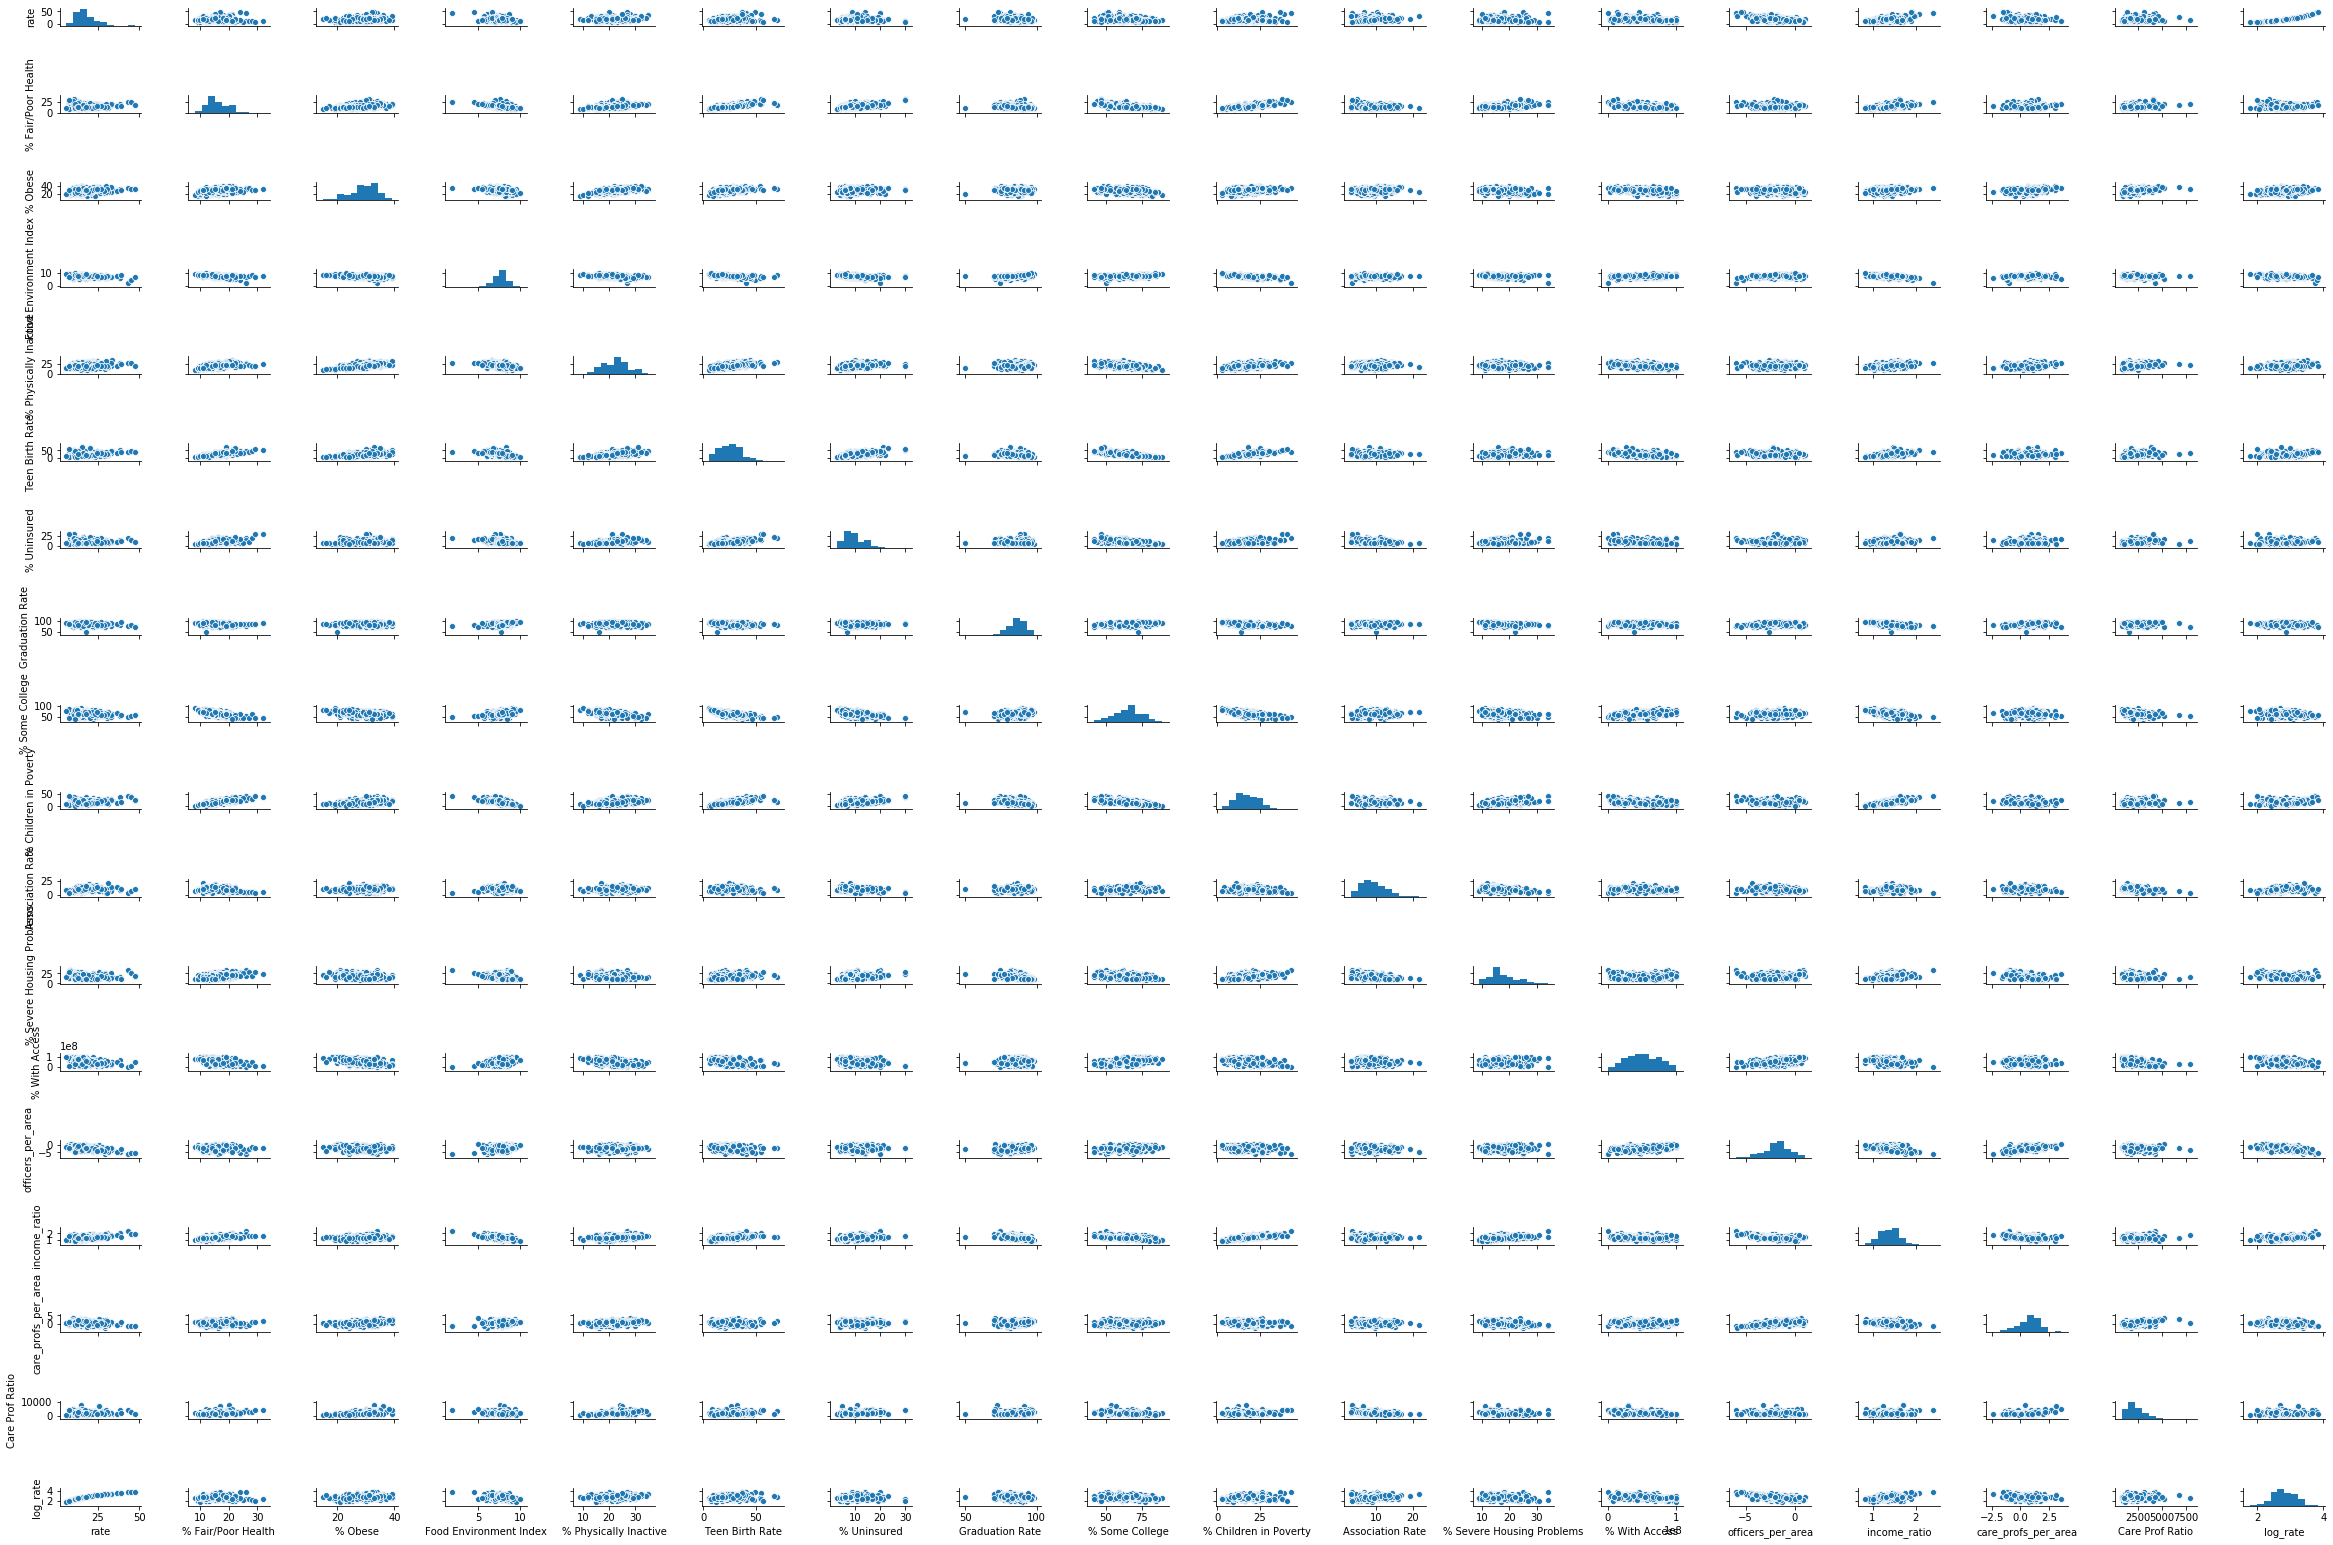

In [338]:
sns.pairplot(df, height=1.2, aspect=1.5);

In [339]:
cols_dropped_from_iterating = [                    
    '% Uninsured' 
]

In [340]:
cols_drop_maybe = [ 
                    'rate', 
                    'log_rate',
                    'Care Prof Ratio'
                    '% With Access', 

]

In [722]:
cols_for_OLS = [
                    'officers_per_area',
                    'Food Environment Index',
                    'Teen Birth Rate',
                    '% Fair/Poor Health',
#                    'Graduation Rate', 
                    '% Severe Housing Problems', 
#                    'care_profs_per_area', 
                    'income_ratio',
#                    'Association Rate',
#                    '% Children in Poverty',
#                    '% Obese',
#                    '% Some College'

                ]

In [723]:
corrdf = df.corr()
corrdf = corrdf[abs(corrdf[:]) < 0.3]
corrdf

,rate,% Fair/Poor Health,% Obese,Food Environment Index,% Physically Inactive,Teen Birth Rate,% Uninsured,Graduation Rate,% Some College,% Children in Poverty,Association Rate,% Severe Housing Problems,% With Access,officers_per_area,income_ratio,care_profs_per_area,Care Prof Ratio,log_rate
rate,nan,0.111,0.196,nan,0.211,nan,0.093,-0.208,-0.262,0.267,0.227,-0.136,nan,nan,nan,-0.254,0.108,nan
% Fair/Poor Health,0.111,nan,nan,nan,nan,nan,nan,-0.154,nan,nan,-0.157,nan,nan,-0.076,nan,-0.030,nan,0.069
% Obese,0.196,nan,nan,nan,nan,nan,0.090,0.070,nan,nan,0.279,nan,nan,-0.116,0.242,nan,nan,0.233
Food Environment Index,nan,nan,nan,nan,nan,nan,nan,0.287,nan,nan,-0.098,-0.209,nan,0.206,nan,0.116,-0.141,nan
% Physically Inactive,0.211,nan,nan,nan,nan,nan,nan,0.048,nan,nan,0.196,-0.247,nan,0.019,nan,nan,nan,0.237
Teen Birth Rate,nan,nan,nan,nan,nan,nan,nan,-0.230,nan,nan,0.046,0.143,nan,-0.198,nan,-0.007,nan,nan
% Uninsured,0.093,nan,0.090,nan,nan,nan,nan,-0.105,nan,nan,-0.234,0.271,-0.274,0.061,0.254,0.037,nan,0.070
Graduation Rate,-0.208,-0.154,0.070,0.287,0.048,-0.230,-0.105,nan,0.265,nan,0.086,nan,-0.091,0.137,nan,0.256,0.043,-0.187
% Some College,-0.262,nan,nan,nan,nan,nan,nan,0.265,nan,nan,0.136,nan,nan,0.222,nan,0.055,nan,-0.239
% Children in Poverty,0.267,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.019,nan,nan,-0.143,nan,-0.156,0.149,0.219


In [724]:
# OLS without patsy


X = df[cols_for_OLS]
y = df.loc[:,"log_rate"].astype(float)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = sm.OLS(y, sm.add_constant(X), data=df)
results = model.fit() 
results.summary()

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_rate   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     54.38
Date:                Wed, 09 Oct 2019   Prob (F-statistic):           4.41e-45
Time:                        21:28:17   Log-Likelihood:                -5.2204
No. Observations:                 305   AIC:                             24.44
Df Residuals:                     298   BIC:                             50.48
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         3.2180      0.255     12.614      0.000       2.716       3.720
officers_per_area            -0.0961      0.013     -7.619      0.000      -0.121      -0.071
Food Environment Index       -0.0767      0.022     -3.538      0.000      -0.119      -0.034
Teen Birth Rate               0.0096      0.002      4.231      0.000       0.005       0.014
% Fair/Poor Health           -0.0348      0.007     -4.885      0.000      -0.049      -0.021
% Severe Housing Problems    -0.0195      0.004     -5.366      0.000      -0.027      -0.012
income_ratio                  0.4663      0.096      4.846      0.000       0.277       0.656
==============================================================================
Omnibus:                        4.376   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.112   Jarque-Bera (JB):                4.185
Skew:                          -0.284   Prob(JB):                        0.123
Kurtosis:                       3.080   Cond. No.                         681.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [725]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,4.000,officers_per_area
1,19.300,Food Environment Index
2,19.700,Teen Birth Rate
3,65.500,% Fair/Poor Health
4,20.500,% Severe Housing Problems
5,58.700,income_ratio


In [726]:
alphavec = 10**np.linspace(-2,2,200)
l1vec = 10**np.linspace(-2,2,200)

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=.2, random_state=3)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=.25, random_state=3)

# models
lm = LinearRegression()
lm_reg = RidgeCV(alphas = alphavec, cv=5)
lm_la = LassoCV(alphas = alphavec, cv=5,)
lm_en = ElasticNetCV(alphas = alphavec, l1_ratio = 0.6, cv=5)


# fit standard OLS
lm.fit(X_trainval, y_trainval)

# feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_trainval_scaled = scaler.transform(X_trainval)


# fit Ridge
lm_reg.fit(X_trainval_scaled, y_trainval)
    
# fit LASSO
lm_la.fit(X_trainval_scaled, y_trainval)
    
# fit ElasticNet
lm_en.fit(X_trainval_scaled, y_trainval)

# scale the test data 
X_test_scaled = scaler.transform(X_test.values)


# fit the test data to the model
lm_pred = lm.predict(X_test)
reg_pred = lm_reg.predict(X_test_scaled)
la_pred = lm_la.predict(X_test_scaled)
en_pred = lm_en.predict(X_test_scaled)


#Mean Absolute Error (MAE)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

# print out results!


print('R^2 values')

print(f'Simple cv r^2: {round((r2_score(y_test, lm_pred)),3)}')
print(f'Ridge cv r^2: {round((r2_score(y_test, reg_pred)),3)}')
print(f'LASSO cv r^2: {round((r2_score(y_test, la_pred)), 3)}')
print(f'ElasticNet cv r^2: {round((r2_score(y_test, en_pred)), 3)}')

print('\nmae values')

lm_mae = round(mae(np.exp(y_test), np.exp(lm_pred)), 2)
reg_mae = round(mae(np.exp(y_test), np.exp(reg_pred)), 2)
la_mae = round(mae(np.exp(y_test), np.exp(la_pred)), 2)
en_mae = round(mae(np.exp(y_test), np.exp(en_pred)), 2)

print(f'Simple mae: {lm_mae}')
print(f'Ridge mae: {reg_mae}')
print(f'LASSO mae: {la_mae}')
print(f'ElasticNet mae: {en_mae}')



R^2 values
Simple cv r^2: 0.454
Ridge cv r^2: 0.462
LASSO cv r^2: 0.486
ElasticNet cv r^2: 0.477

mae values
Simple mae: 3.24
Ridge mae: 3.22
LASSO mae: 3.2
ElasticNet mae: 3.2


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [734]:
b = list(zip((cols_for_OLS), lm.coef_, lm_reg.coef_, lm_la.coef_, lm_en.coef_))

coefs = pd.DataFrame.from_records(b, columns =['feature', 'OLS', 'Ridge', 'LASSO', 'ElasticNet']) 
col = coefs.loc[: , "Ridge":"ElasticNet"]

coefs['mean'] = col.mean(axis=1)
coefs['stdev'] = col.std(axis=1)

coefs['mean_abs'] = abs(coefs['mean'])
coefs['mean_abs_exp'] = np.exp(coefs['mean_abs'])

pd.set_option('display.float_format', lambda x: '%.3f' % x)

coefs['scalers'] = scaler.scale_

coefs['LASSO un-scaled betas'] = abs(coefs['LASSO'] / coefs['scalers'])

coefs = coefs.sort_values('LASSO un-scaled betas', ascending = False)

coefs



,feature,OLS,Ridge,LASSO,ElasticNet,mean,stdev,mean_abs,mean_abs_exp,scalers,LASSO un-scaled betas
5,income_ratio,0.440,0.100,0.087,0.093,0.093,0.006,0.093,1.098,0.233,0.373
0,officers_per_area,-0.095,-0.123,-0.124,-0.123,-0.123,0.001,0.123,1.131,1.287,0.096
1,Food Environment Index,-0.094,-0.077,-0.070,-0.073,-0.073,0.003,0.073,1.076,0.825,0.085
3,% Fair/Poor Health,-0.037,-0.129,-0.087,-0.106,-0.107,0.021,0.107,1.113,3.782,0.023
4,% Severe Housing Problems,-0.022,-0.099,-0.096,-0.097,-0.097,0.002,0.097,1.102,4.577,0.021
2,Teen Birth Rate,0.011,0.117,0.084,0.099,0.100,0.016,0.100,1.105,11.355,0.007


In [737]:
officers_per_area_coef = np.exp(0.096)
officers_per_area_coef

1.1007590639939788

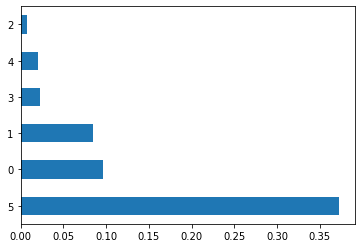

In [738]:
d = coefs['LASSO un-scaled betas'].plot.barh()

Text(0, 0.5, 'Expected')

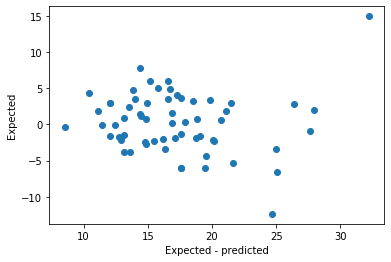

In [739]:
plt.scatter(np.exp(la_pred), np.exp(y_test)-np.exp(la_pred))
plt.xlabel('Expected - predicted')
plt.ylabel('Expected')

Text(0, 0.5, 'Rate')

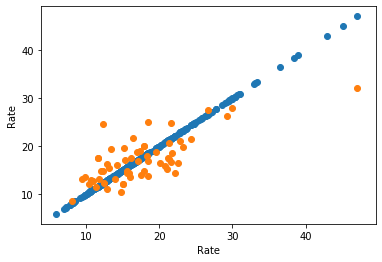

In [740]:
plt.scatter(np.exp(y), np.exp(y))
plt.scatter(np.exp(y_test), np.exp(la_pred))
plt.xlabel('Rate')
plt.ylabel('Rate')